# Testing tf-agents library on Wordle Env

This is a recreation of the TF Agents DQN tutorial:
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [1]:
from tqdm import tqdm
from wordle_rl import WordleEnv

# import gym

import tensorflow as tf
import numpy as np

import tf_agents
import reverb

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

2022-02-16 18:26:11.643520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 18:26:11.643580: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1) Hyperparameters of this demo

In [6]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### 2) Convert Gym envs to TFPy envs

Two things are happening here:
1) We're initializing a separate train and eval env
2) We're convering our custom OpenAI Gym env into a TF python env

In [3]:
env = WordleEnv("config.json")
env = tf_agents.environments.gym_wrapper.GymWrapper(env)

gym_train_env = WordleEnv("config.json")
gym_eval_env = WordleEnv("config.json")

py_train_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_train_env)
py_eval_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_eval_env)

train_env = tf_py_environment.TFPyEnvironment(py_train_env)
eval_env = tf_py_environment.TFPyEnvironment(py_eval_env)

### 3) Define a TF agent

TF-Agents library comes with several different algorithms implemented. Here we'll use a DQN. 

Instantiating a DQN with TF-Agents involves: 
1) Defining a Q Network object
2) Feeding that Q Network to a DQN agent object

The "Q Network" is a neural network model that takes env state observations as input and computes Q values as output. Q values here are reward probability estimations for given actions in given env states.

In [4]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2022-02-16 18:27:01.312679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 18:27:01.312753: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 18:27:01.312782: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f5bfd35a90d8): /proc/driver/nvidia/version does not exist
2022-02-16 18:27:01.314942: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
agent.policy

In [10]:
agent.collect_policy

### 4) Define a Replay Buffer

This is technically optional. The replay buffer will improve data efficiency, that is we will get more information from each game as the replay buffer lets us replay games to see different outcomes from certain states.

In [11]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(10656)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(60,), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(29, dtype=uint8)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [12]:
# table_name = 'uniform_table'
# replay_buffer_signature = tensor_spec.from_spec(
#       agent.collect_data_spec)
# replay_buffer_signature = tensor_spec.add_outer_dim(
#     replay_buffer_signature)

# table = reverb.Table(
#     table_name,
#     max_size=replay_buffer_max_length,
#     sampler=reverb.selectors.Uniform(),
#     remover=reverb.selectors.Fifo(),
#     rate_limiter=reverb.rate_limiters.MinSize(1),
#     signature=replay_buffer_signature)

# reverb_server = reverb.Server([table])

# replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
#     agent.collect_data_spec,
#     table_name=table_name,
#     sequence_length=2,
#     local_server=reverb_server)

# rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
#   replay_buffer.py_client,
#   table_name,
#   sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmprlz9zac4.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmprlz9zac4
[reverb/cc/platform/default/server.cc:71] Started replay server on port 15931


### 5) Train our agent

In [8]:
time_step = env.reset()

In [9]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

In [10]:
replay_buffer_capacity = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [11]:
replay_observer = [replay_buffer.add_batch]

collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [12]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [13]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

In [67]:
%%time

num_iterations = 2000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}


# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_env.reset()

# Create a driver to collect experience.
collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2)

iterator = iter(dataset)

for _ in tqdm(range(num_iterations)):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_op.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    # print(time_step)
    experience, unused_info = next(iterator)
    # print(experience)
    train_loss = agent.train(experience).loss
    # print(train_loss)
    step = agent.train_step_counter.numpy()
    # print(step)
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

  5%|▌         | 101/2000 [00:13<08:05,  3.92it/s]

step = 100: Average Return = 203.1999969482422


 10%|▉         | 199/2000 [00:27<04:21,  6.88it/s]

step = 200: loss = 1448.7625732421875


 10%|█         | 201/2000 [00:28<07:20,  4.09it/s]

step = 200: Average Return = 239.6999969482422


 15%|█▌        | 301/2000 [00:40<05:51,  4.84it/s]

step = 300: Average Return = 204.60000610351562


 20%|█▉        | 399/2000 [00:53<03:09,  8.45it/s]

step = 400: loss = 1404.6910400390625


 20%|██        | 401/2000 [00:54<05:05,  5.24it/s]

step = 400: Average Return = 283.20001220703125


 25%|██▌       | 501/2000 [01:06<04:33,  5.47it/s]

step = 500: Average Return = 175.39999389648438


 30%|██▉       | 599/2000 [01:19<04:23,  5.31it/s]

step = 600: loss = 2597.307373046875


 30%|███       | 601/2000 [01:20<06:52,  3.39it/s]

step = 600: Average Return = 313.3999938964844


 35%|███▌      | 701/2000 [01:35<04:10,  5.19it/s]

step = 700: Average Return = 124.5


 40%|███▉      | 799/2000 [01:49<02:40,  7.49it/s]

step = 800: loss = 4061.17919921875


 40%|████      | 801/2000 [01:50<04:09,  4.80it/s]

step = 800: Average Return = 246.1999969482422


 45%|████▌     | 901/2000 [02:05<03:52,  4.72it/s]

step = 900: Average Return = 148.8000030517578


 50%|████▉     | 999/2000 [02:18<02:13,  7.47it/s]

step = 1000: loss = 4450.07177734375


 50%|█████     | 1001/2000 [02:19<04:06,  4.06it/s]

step = 1000: Average Return = 244.39999389648438


 55%|█████▌    | 1101/2000 [02:33<03:41,  4.06it/s]

step = 1100: Average Return = 223.6999969482422


 60%|█████▉    | 1199/2000 [02:47<03:18,  4.04it/s]

step = 1200: loss = 2822.11376953125


 60%|██████    | 1201/2000 [02:48<04:37,  2.88it/s]

step = 1200: Average Return = 135.5


 65%|██████▌   | 1301/2000 [03:01<02:48,  4.16it/s]

step = 1300: Average Return = 249.0


 70%|██████▉   | 1399/2000 [03:14<01:14,  8.03it/s]

step = 1400: loss = 1103.5096435546875


 70%|███████   | 1401/2000 [03:14<01:59,  5.01it/s]

step = 1400: Average Return = 164.39999389648438


 75%|███████▌  | 1501/2000 [03:29<01:49,  4.56it/s]

step = 1500: Average Return = 189.5


 80%|███████▉  | 1599/2000 [03:42<00:48,  8.30it/s]

step = 1600: loss = 4149.16845703125


 80%|████████  | 1601/2000 [03:43<01:31,  4.34it/s]

step = 1600: Average Return = 204.3000030517578


 85%|████████▌ | 1700/2000 [03:56<01:01,  4.90it/s]

step = 1700: Average Return = 244.0


 90%|████████▉ | 1799/2000 [04:07<00:25,  7.95it/s]

step = 1800: loss = 1468.1722412109375


 90%|█████████ | 1801/2000 [04:08<00:35,  5.57it/s]

step = 1800: Average Return = 203.39999389648438


 95%|█████████▌| 1901/2000 [04:20<00:20,  4.95it/s]

step = 1900: Average Return = 180.89999389648438


100%|█████████▉| 1999/2000 [04:38<00:00,  5.26it/s]

step = 2000: loss = 2390.112060546875


100%|██████████| 2000/2000 [04:39<00:00,  7.15it/s]

step = 2000: Average Return = 160.39999389648438
CPU times: user 4min 56s, sys: 8.71 s, total: 5min 5s
Wall time: 4min 40s


### 6) Evaluate our agent

We need a way to see how good our policy is performing on our environment

In [15]:
import matplotlib.pyplot as plt

In [16]:
returns

[160.9, 228.3, 208.9, 333.6, 130.3, 232.7, 249.3, 307.5, 148.3, 200.2, 200.5]

Text(0.5, 0, 'Iterations')

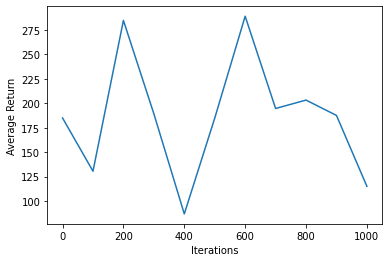

In [56]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
# plt.ylim(top=250)

In [18]:
import utils

In [66]:
utils.play_a_tfagents_game(eval_env,agent)

This game's correct word is: 'hemps'

RL Agent's guesses:
p e n e s 
- - - - - 
g l e e s 
- - - - - 
s e n g i 
- - - - - 
n i s e i 
- - - - - 
o m i t s 
- - - - - 
n o n e s 
- - - - - 

Final Result:
[[[16  5 14  5 19]
  [ 7 12  5  5 19]
  [19  5 14  7  9]
  [14  9 19  5  9]
  [15 13  9 20 19]
  [14 15 14  5 19]]

 [[28 29 27 28 29]
  [27 27 28 28 29]
  [28 29 27 27 27]
  [27 27 28 28 27]
  [27 28 27 27 29]
  [27 27 27 28 29]]]
